In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import warnings
warnings.filterwarnings('ignore')

# Set file paths
database_location = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/Database/"
output_location_predictions = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/ARIMA/predictions/"
output_location_metrics = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/ARIMA/metrics/"

# Ensure directories exist
os.makedirs(output_location_predictions, exist_ok=True)
os.makedirs(output_location_metrics, exist_ok=True)

stock_files = {
    "AAPL": "Pre_Processed_AAPL.csv",
    "TSLA": "Pre_Processed_TSLA.csv",
    "GOOG": "Pre_Processed_GOOG.csv",
    "MSFT": "Pre_Processed_MSFT.csv",
    "AMZN": "Pre_Processed_AMZN.csv"
}


In [5]:
def load_and_process_stock_data(stock_name, file_path):
    # Load data
    stock_data = pd.read_csv(file_path)
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    stock_data['log Adj. Close'] = np.log(stock_data['Adj. Close'])
    
    # Check stationarity
    result = adfuller(stock_data['log Adj. Close'], autolag='AIC')
    print(f"\nDickey-Fuller Test for {stock_name}:")
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    
    # Split data into training and test sets
    train_data = stock_data[stock_data['Date'] < '2020-10-01']
    test_data = stock_data[stock_data['Date'] >= '2020-10-01'].reset_index(drop=True)
    print(f"Number of rows in test_data for {stock_name}: {len(test_data)}")
    print(f"split percentage: {len(train_data) / len(stock_data)}")
    
    # Auto ARIMA Model to determine the best order
    auto_model = auto_arima(train_data['log Adj. Close'], seasonal=False, error_action='ignore', suppress_warnings=True)
    print(f"\nAuto ARIMA Model Summary for {stock_name}:\n", auto_model.summary())
    best_order = auto_model.order

    # Fit the ARIMA Model with the best order from auto_arima
    arima_model = ARIMA(train_data['log Adj. Close'], order=best_order)
    arima_model_fit = arima_model.fit()
    
    # Forecast for the length of the test set
    forecast = arima_model_fit.forecast(steps=len(test_data))
    predictions = np.exp(forecast)  # Back-transform to original scale
    print(f"Number of rows in predictions for {stock_name}: {len(predictions)}")
    
    # Align predictions with test data dates
    predictions_df = pd.DataFrame({
        'Date': test_data['Date'].values,
        'Predicted_Adj_Close': predictions
    }).reset_index(drop=True)
    print(f"Number of rows in predictions_df for {stock_name}: {len(predictions_df)}")
    
    # Save predictions and actual data to CSV
    output_df = pd.concat([
        test_data[['Date', 'Adj. Close']].reset_index(drop=True),
        predictions_df['Predicted_Adj_Close']
    ], axis=1)
    output_df.columns = ['Date', 'Actual_Adj_Close', 'Predicted_Adj_Close']
    output_df.to_csv(f"{output_location_predictions}{stock_name}_predictions.csv", index=False)

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(train_data['Date'], np.exp(train_data['log Adj. Close']), label='Train Data')
    plt.plot(output_df['Date'], output_df['Actual_Adj_Close'], label='Test Data')
    plt.plot(output_df['Date'], output_df['Predicted_Adj_Close'], label='Predictions')
    plt.title(f"{stock_name} Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Closing Price")
    plt.legend(loc='best')
    plt.show()
    
    # Calculate evaluation metrics
    mse = mean_squared_error(test_data['Adj. Close'], predictions)
    mae = mean_absolute_error(test_data['Adj. Close'], predictions)
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs(predictions - test_data['Adj. Close']) / np.abs(test_data['Adj. Close']))
    
    print(f"\nEvaluation Metrics for {stock_name}:")
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')
    
    return {
        "Stock": stock_name,
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }


Dickey-Fuller Test for AAPL:
Test Statistic: 0.24385640736855602
p-value: 0.9746168379035189
Number of rows in test_data for AAPL: 102
split percentage: 0.934151065203357

Auto ARIMA Model Summary for AAPL:
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1447
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3721.627
Date:                Wed, 13 Nov 2024   AIC                          -7437.254
Time:                        04:41:02   BIC                          -7421.424
Sample:                             0   HQIC                         -7431.346
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
i

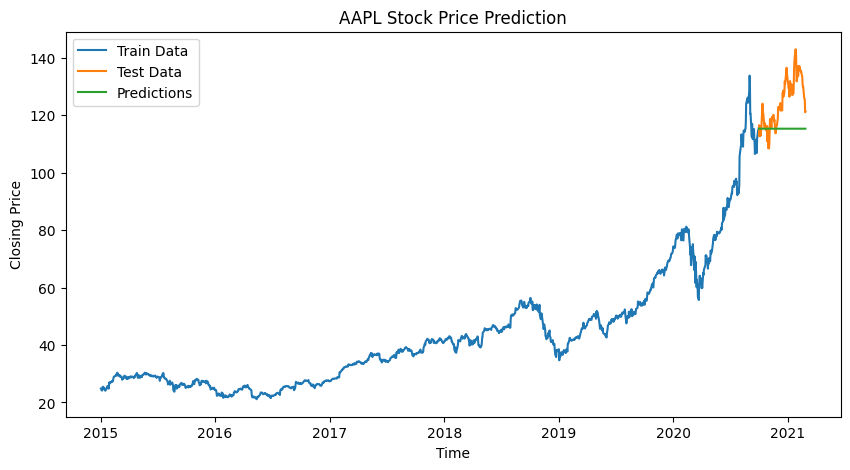


Evaluation Metrics for AAPL:
MSE: 155.83976213512696
MAE: 9.918578131514806
RMSE: 12.483579700355461
MAPE: nan

Dickey-Fuller Test for TSLA:
Test Statistic: 1.4063610465056235
p-value: 0.9971428483915683
Number of rows in test_data for TSLA: 102
split percentage: 0.934151065203357

Auto ARIMA Model Summary for TSLA:
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1447
Model:               SARIMAX(5, 2, 2)   Log Likelihood                2805.968
Date:                Wed, 13 Nov 2024   AIC                          -5593.936
Time:                        04:41:10   BIC                          -5546.453
Sample:                             0   HQIC                         -5576.214
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z     

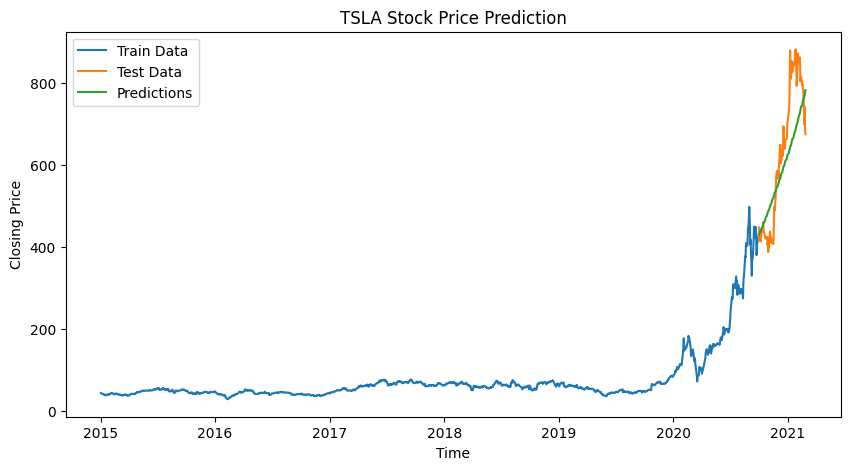


Evaluation Metrics for TSLA:
MSE: 9169.66993982232
MAE: 78.03840592751243
RMSE: 95.75839357373493
MAPE: nan

Dickey-Fuller Test for GOOG:
Test Statistic: -0.667651492222775
p-value: 0.8549515724339993
Number of rows in test_data for GOOG: 102
split percentage: 0.934151065203357

Auto ARIMA Model Summary for GOOG:
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1447
Model:               SARIMAX(1, 1, 2)   Log Likelihood                3861.246
Date:                Wed, 13 Nov 2024   AIC                          -7712.492
Time:                        04:41:13   BIC                          -7686.109
Sample:                             0   HQIC                         -7702.645
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>

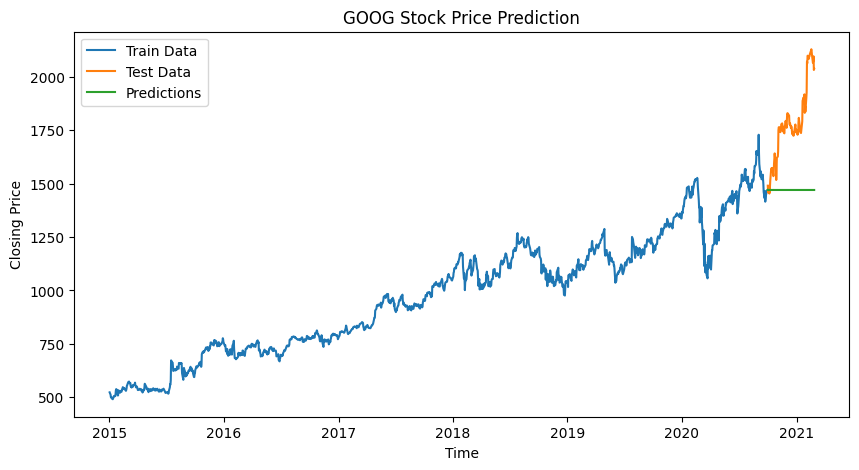


Evaluation Metrics for GOOG:
MSE: 126880.35427335007
MAE: 311.64530805274643
RMSE: 356.202687066437
MAPE: nan

Dickey-Fuller Test for MSFT:
Test Statistic: 0.31301008798128344
p-value: 0.9779335706423877
Number of rows in test_data for MSFT: 102
split percentage: 0.934151065203357

Auto ARIMA Model Summary for MSFT:
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1447
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3828.056
Date:                Wed, 13 Nov 2024   AIC                          -7650.112
Time:                        04:41:14   BIC                          -7634.282
Sample:                             0   HQIC                         -7644.204
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z     

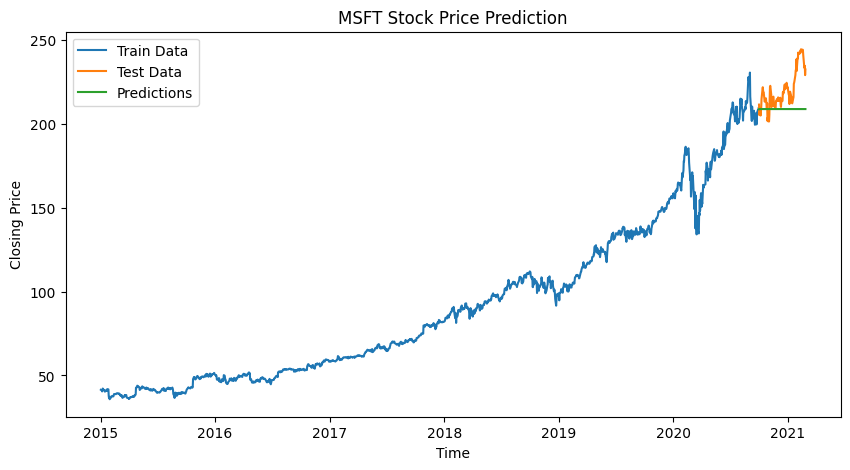


Evaluation Metrics for MSFT:
MSE: 262.2849983427874
MAE: 12.310653845279438
RMSE: 16.195215291646708
MAPE: nan

Dickey-Fuller Test for AMZN:
Test Statistic: -1.8612806997647684
p-value: 0.35048925041549694
Number of rows in test_data for AMZN: 102
split percentage: 0.934151065203357

Auto ARIMA Model Summary for AMZN:
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1447
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3656.945
Date:                Wed, 13 Nov 2024   AIC                          -7309.891
Time:                        04:41:15   BIC                          -7299.338
Sample:                             0   HQIC                         -7305.952
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z   

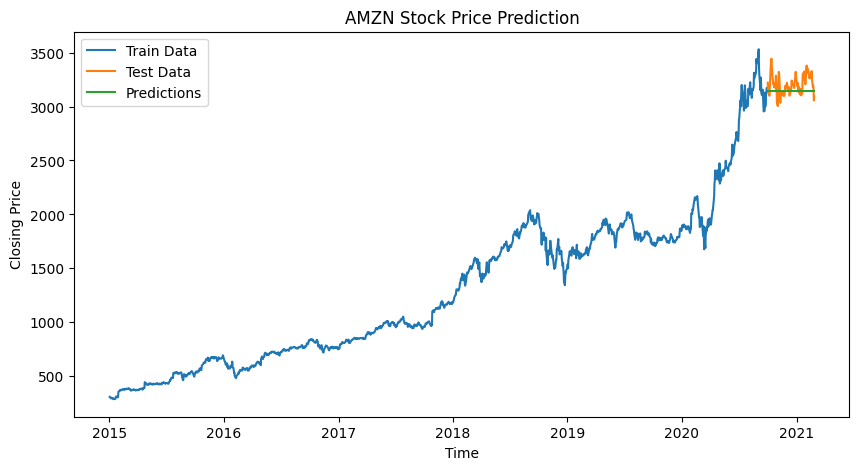


Evaluation Metrics for AMZN:
MSE: 11173.241312745044
MAE: 83.2149999999998
RMSE: 105.70355392674857
MAPE: nan

All Stock Evaluation Metrics saved to metrics.csv.


In [6]:
# Loop through each stock and process
metrics_list = []
for stock, file in stock_files.items():
    file_path = database_location + file
    metrics = load_and_process_stock_data(stock, file_path)
    metrics_list.append(metrics)

# Save all metrics to a single CSV file
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv(f"{output_location_metrics}metrics.csv", index=False)

print("\nAll Stock Evaluation Metrics saved to metrics.csv.")


Dickey-Fuller Test for AAPL (Dataset-A):
Test Statistic: 0.24385640736855602
p-value: 0.9746168379035189
Number of rows in test_data for AAPL (Dataset-A): 254
Split percentage: 0.8360232408005165

Auto ARIMA Model Summary for AAPL (Dataset-A):
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1295
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3533.937
Date:                Fri, 22 Nov 2024   AIC                          -7063.873
Time:                        13:42:00   BIC                          -7053.542
Sample:                             0   HQIC                         -7059.996
                               - 1295                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

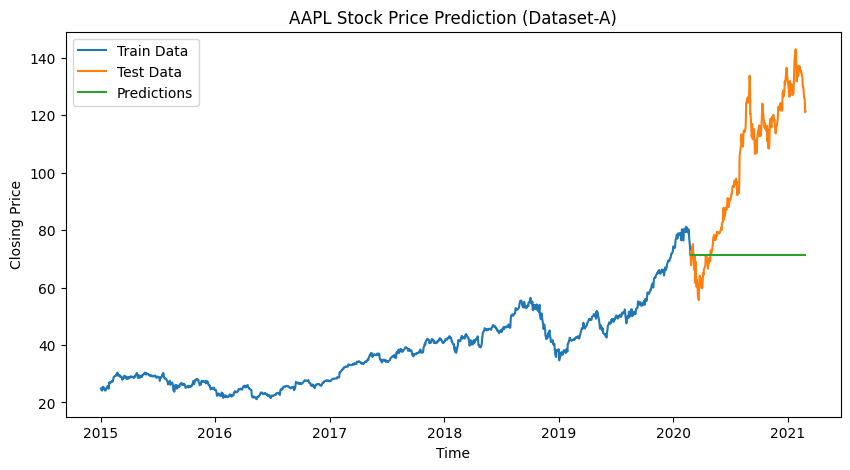


Evaluation Metrics for AAPL (Dataset-A):
MSE: 1572.240286614175
MAE: 33.37377952755908
RMSE: 39.651485301488705
MAPE: nan

Dickey-Fuller Test for TSLA (Dataset-A):
Test Statistic: 1.4063610465056235
p-value: 0.9971428483915683
Number of rows in test_data for TSLA (Dataset-A): 254
Split percentage: 0.8360232408005165

Auto ARIMA Model Summary for TSLA (Dataset-A):
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1295
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2713.518
Date:                Fri, 22 Nov 2024   AIC                          -5425.035
Time:                        13:42:01   BIC                          -5419.870
Sample:                             0   HQIC                         -5423.097
                               - 1295                                         
Covariance Type:                  opg                                         


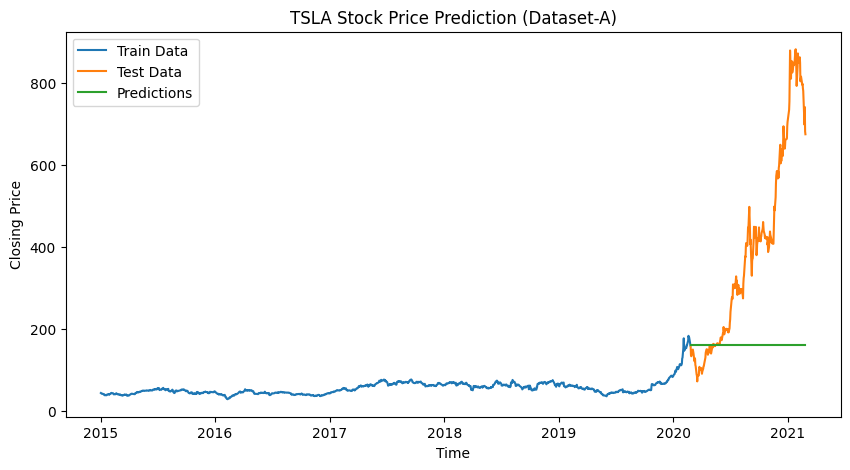


Evaluation Metrics for TSLA (Dataset-A):
MSE: 108895.53071299211
MAE: 244.90877952755903
RMSE: 329.99322828353934
MAPE: nan

Dickey-Fuller Test for GOOG (Dataset-A):
Test Statistic: -0.667651492222775
p-value: 0.8549515724339993
Number of rows in test_data for GOOG (Dataset-A): 254
Split percentage: 0.8360232408005165

Auto ARIMA Model Summary for GOOG (Dataset-A):
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1295
Model:               SARIMAX(1, 1, 2)   Log Likelihood                3602.164
Date:                Fri, 22 Nov 2024   AIC                          -7194.328
Time:                        13:42:04   BIC                          -7168.501
Sample:                             0   HQIC                         -7184.636
                               - 1295                                         
Covariance Type:                  opg                                        

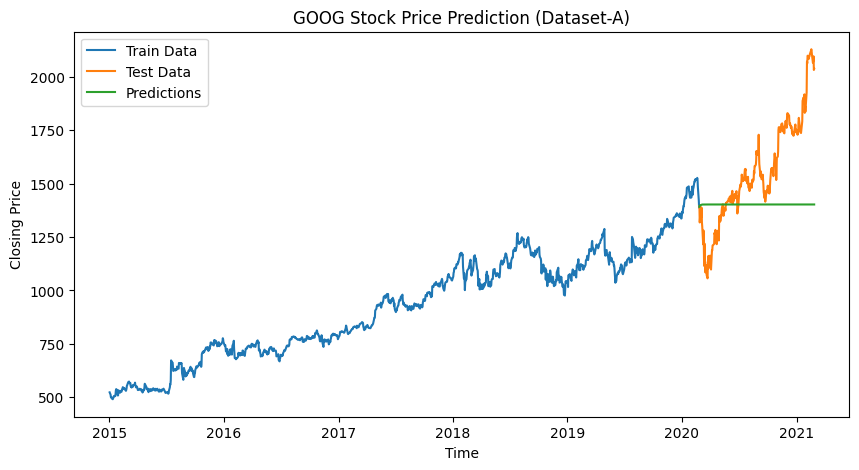


Evaluation Metrics for GOOG (Dataset-A):
MSE: 82361.51942565003
MAE: 221.4093467064275
RMSE: 286.9869673445992
MAPE: nan

Dickey-Fuller Test for MSFT (Dataset-A):
Test Statistic: 0.31301008798128344
p-value: 0.9779335706423877
Number of rows in test_data for MSFT (Dataset-A): 254
Split percentage: 0.8360232408005165

Auto ARIMA Model Summary for MSFT (Dataset-A):
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1295
Model:               SARIMAX(0, 1, 2)   Log Likelihood                3627.515
Date:                Fri, 22 Nov 2024   AIC                          -7247.031
Time:                        13:42:05   BIC                          -7226.369
Sample:                             0   HQIC                         -7239.277
                               - 1295                                         
Covariance Type:                  opg                                         


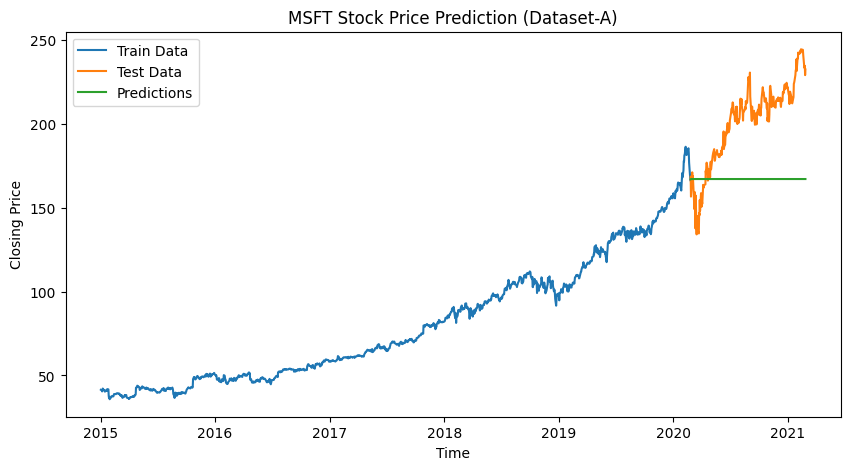


Evaluation Metrics for MSFT (Dataset-A):
MSE: 1749.151357545798
MAE: 37.10926096062944
RMSE: 41.822856879292665
MAPE: nan

Dickey-Fuller Test for AMZN (Dataset-A):
Test Statistic: -1.8612806997647684
p-value: 0.35048925041549694
Number of rows in test_data for AMZN (Dataset-A): 254
Split percentage: 0.8360232408005165

Auto ARIMA Model Summary for AMZN (Dataset-A):
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1295
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3344.999
Date:                Fri, 22 Nov 2024   AIC                          -6685.999
Time:                        13:42:06   BIC                          -6675.668
Sample:                             0   HQIC                         -6682.122
                               - 1295                                         
Covariance Type:                  opg                                        

/mnt/External/8TBHDD/Keyur/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


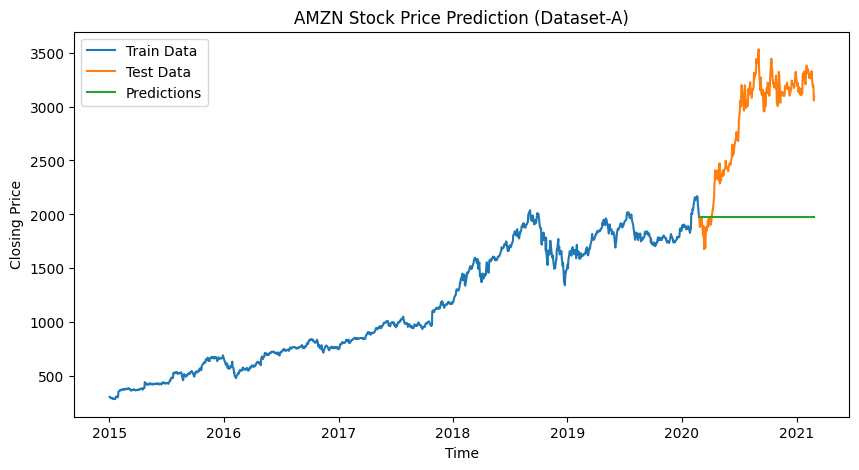


Evaluation Metrics for AMZN (Dataset-A):
MSE: 1031331.9320937019
MAE: 913.6466929133865
RMSE: 1015.5451403525606
MAPE: nan

Metrics for Dataset-A saved to /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/ARIMA/metrics/Dataset-A/metrics.csv.

Dickey-Fuller Test for AAPL (Dataset-B):
Test Statistic: 0.24385640736855602
p-value: 0.9746168379035189
Number of rows in test_data for AAPL (Dataset-B): 127
Split percentage: 0.9180116204002582

Auto ARIMA Model Summary for AAPL (Dataset-B):
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1422
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3684.218
Date:                Fri, 22 Nov 2024   AIC                          -7362.437
Time:                        13:42:08   BIC                          -7346.659
Sample:                             0   HQIC                         -7356.543
                               - 1422

/mnt/External/8TBHDD/Keyur/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


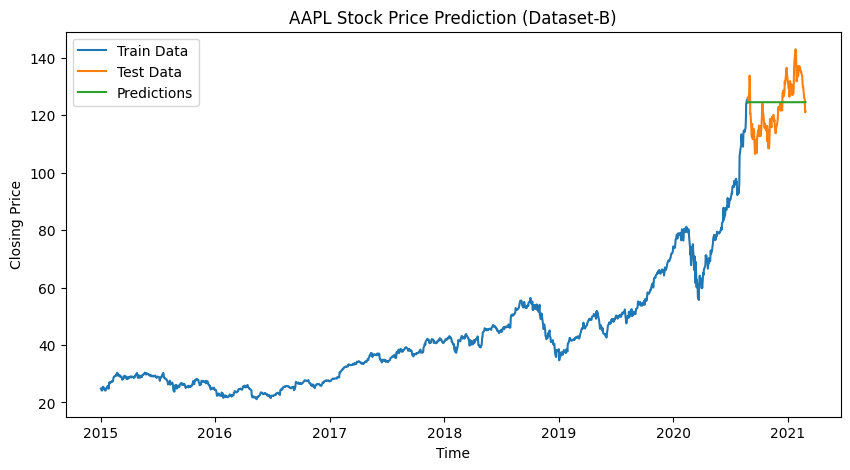


Evaluation Metrics for AAPL (Dataset-B):
MSE: 79.90381258335083
MAE: 7.756123324381889
RMSE: 8.938893252710361
MAPE: nan

Dickey-Fuller Test for TSLA (Dataset-B):
Test Statistic: 1.4063610465056235
p-value: 0.9971428483915683
Number of rows in test_data for TSLA (Dataset-B): 127
Split percentage: 0.9180116204002582

Auto ARIMA Model Summary for TSLA (Dataset-B):
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1422
Model:               SARIMAX(5, 2, 1)   Log Likelihood                2811.238
Date:                Fri, 22 Nov 2024   AIC                          -5608.475
Time:                        13:42:16   BIC                          -5571.666
Sample:                             0   HQIC                         -5594.725
                               - 1422                                         
Covariance Type:                  opg                                         
 

/mnt/External/8TBHDD/Keyur/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


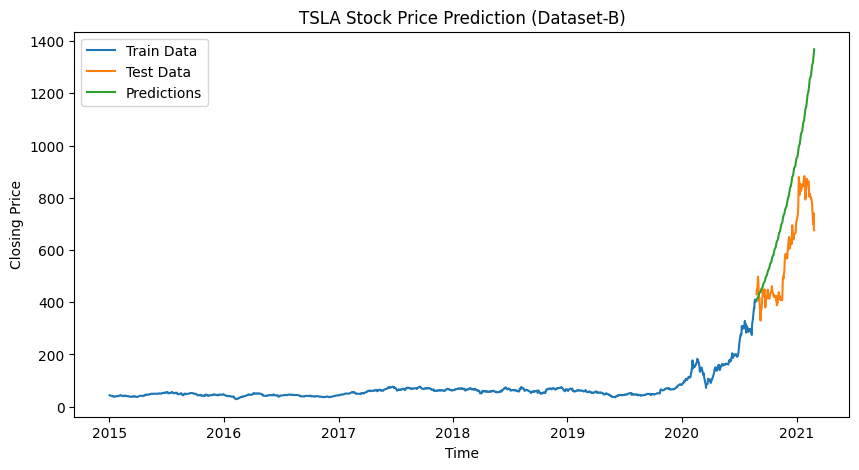


Evaluation Metrics for TSLA (Dataset-B):
MSE: 64277.275478618074
MAE: 213.80096994144
RMSE: 253.52963432036515
MAPE: nan

Dickey-Fuller Test for GOOG (Dataset-B):
Test Statistic: -0.667651492222775
p-value: 0.8549515724339993
Number of rows in test_data for GOOG (Dataset-B): 127
Split percentage: 0.9180116204002582

Auto ARIMA Model Summary for GOOG (Dataset-B):
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1422
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3799.391
Date:                Fri, 22 Nov 2024   AIC                          -7592.781
Time:                        13:42:18   BIC                          -7577.004
Sample:                             0   HQIC                         -7586.888
                               - 1422                                         
Covariance Type:                  opg                                         
 

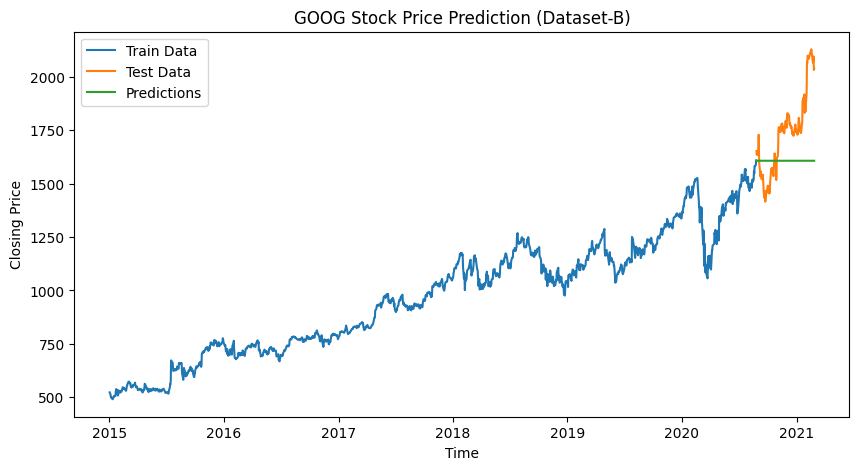


Evaluation Metrics for GOOG (Dataset-B):
MSE: 51011.841696733114
MAE: 180.51997626465214
RMSE: 225.85801224825545
MAPE: nan

Dickey-Fuller Test for MSFT (Dataset-B):
Test Statistic: 0.31301008798128344
p-value: 0.9779335706423877
Number of rows in test_data for MSFT (Dataset-B): 127
Split percentage: 0.9180116204002582

Auto ARIMA Model Summary for MSFT (Dataset-B):
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1422
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3775.407
Date:                Fri, 22 Nov 2024   AIC                          -7544.814
Time:                        13:42:19   BIC                          -7529.037
Sample:                             0   HQIC                         -7538.921
                               - 1422                                         
Covariance Type:                  opg                                       

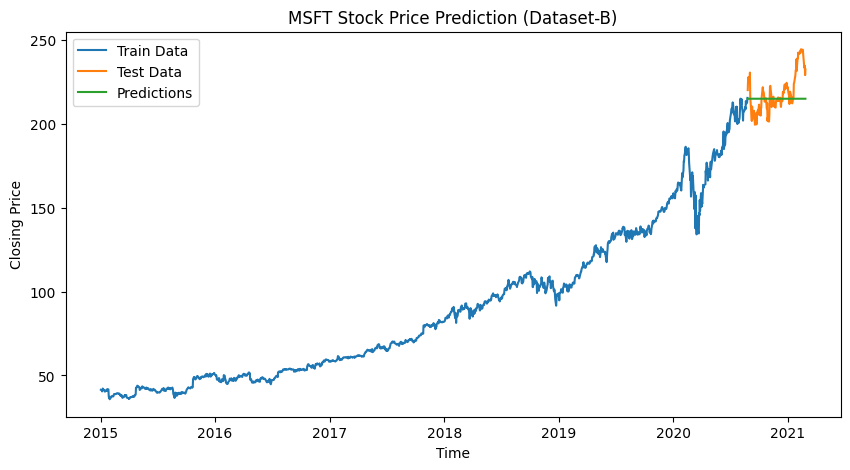


Evaluation Metrics for MSFT (Dataset-B):
MSE: 148.45604009482014
MAE: 8.94671503463247
RMSE: 12.184253776691461
MAPE: nan

Dickey-Fuller Test for AMZN (Dataset-B):
Test Statistic: -1.8612806997647684
p-value: 0.35048925041549694
Number of rows in test_data for AMZN (Dataset-B): 127
Split percentage: 0.9180116204002582

Auto ARIMA Model Summary for AMZN (Dataset-B):
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1422
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3604.126
Date:                Fri, 22 Nov 2024   AIC                          -7204.252
Time:                        13:42:20   BIC                          -7193.734
Sample:                             0   HQIC                         -7200.323
                               - 1422                                         
Covariance Type:                  opg                                        

/mnt/External/8TBHDD/Keyur/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


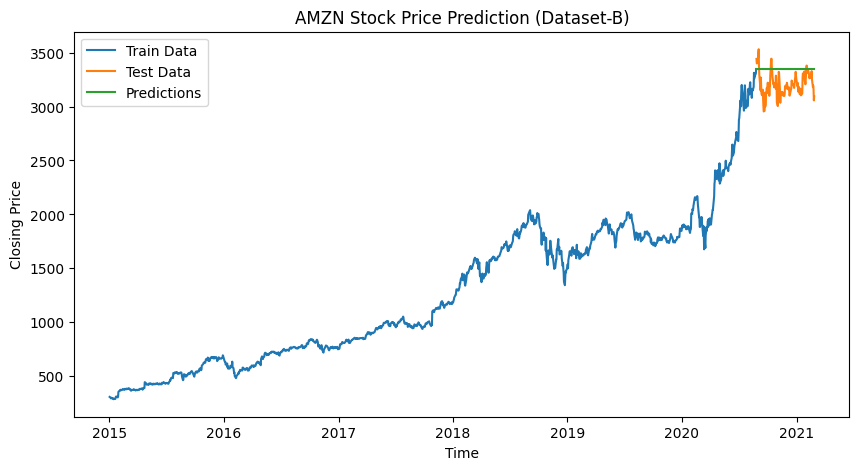


Evaluation Metrics for AMZN (Dataset-B):
MSE: 31797.58708818879
MAE: 155.07921259842468
RMSE: 178.31877940415808
MAPE: nan

Metrics for Dataset-B saved to /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/ARIMA/metrics/Dataset-B/metrics.csv.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import math
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Define datasets with time periods
datasets = {
    "Dataset-A": {
        "start_date": "2015-01-02",
        "end_date": "2020-02-26",
        "pred_end_date": "2021-02-26"
    },
    "Dataset-B": {
        "start_date": "2015-01-02",
        "end_date": "2020-08-26",
        "pred_end_date": "2021-02-26"
    }
}

# Define file paths
database_location = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/Database/"
output_location_predictions = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/ARIMA/predictions/"
output_location_metrics = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/ARIMA/metrics/"

# Ensure directories exist
os.makedirs(output_location_predictions, exist_ok=True)
os.makedirs(output_location_metrics, exist_ok=True)

# Stock files
stock_files = {
    "AAPL": "Pre_Processed_AAPL.csv",
    "TSLA": "Pre_Processed_TSLA.csv",
    "GOOG": "Pre_Processed_GOOG.csv",
    "MSFT": "Pre_Processed_MSFT.csv",
    "AMZN": "Pre_Processed_AMZN.csv"
}

# Function to load and process stock data
def load_and_process_stock_data(stock_name, file_path, start_date, end_date, pred_end_date, dataset_name):
    # Load data
    stock_data = pd.read_csv(file_path)
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    stock_data['log Adj. Close'] = np.log(stock_data['Adj. Close'])

    # Check stationarity
    result = adfuller(stock_data['log Adj. Close'], autolag='AIC')
    print(f"\nDickey-Fuller Test for {stock_name} ({dataset_name}):")
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

    # Split data into training and test sets
    train_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] < end_date)]
    test_data = stock_data[(stock_data['Date'] >= end_date) & (stock_data['Date'] <= pred_end_date)].reset_index(drop=True)
    print(f"Number of rows in test_data for {stock_name} ({dataset_name}): {len(test_data)}")
    print(f"Split percentage: {len(train_data) / len(stock_data)}")

    # Auto ARIMA Model to determine the best order
    auto_model = auto_arima(train_data['log Adj. Close'], seasonal=False, error_action='ignore', suppress_warnings=True)
    print(f"\nAuto ARIMA Model Summary for {stock_name} ({dataset_name}):\n", auto_model.summary())
    best_order = auto_model.order

    # Fit the ARIMA Model with the best order from auto_arima
    arima_model = ARIMA(train_data['log Adj. Close'], order=best_order)
    arima_model_fit = arima_model.fit()

    # Forecast for the length of the test set
    forecast = arima_model_fit.forecast(steps=len(test_data))
    predictions = np.exp(forecast)  # Back-transform to original scale

    # Align predictions with test data dates
    predictions_df = pd.DataFrame({
        'Date': test_data['Date'].values,
        'Predicted_Adj_Close': predictions
    }).reset_index(drop=True)

    # Save predictions and actual data to CSV
    output_df = pd.concat([
        test_data[['Date', 'Adj. Close']].reset_index(drop=True),
        predictions_df['Predicted_Adj_Close']
    ], axis=1)
    output_df.columns = ['Date', 'Actual_Adj_Close', 'Predicted_Adj_Close']
    predictions_file = os.path.join(output_location_predictions, dataset_name, f"{stock_name}_predictions.csv")
    output_df.to_csv(predictions_file, index=False)

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(train_data['Date'], np.exp(train_data['log Adj. Close']), label='Train Data')
    plt.plot(output_df['Date'], output_df['Actual_Adj_Close'], label='Test Data')
    plt.plot(output_df['Date'], output_df['Predicted_Adj_Close'], label='Predictions')
    plt.title(f"{stock_name} Stock Price Prediction ({dataset_name})")
    plt.xlabel("Time")
    plt.ylabel("Closing Price")
    plt.legend(loc='best')
    plt.show()

    # Calculate evaluation metrics
    mse = mean_squared_error(test_data['Adj. Close'], predictions)
    mae = mean_absolute_error(test_data['Adj. Close'], predictions)
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs(predictions - test_data['Adj. Close']) / np.abs(test_data['Adj. Close']))

    print(f"\nEvaluation Metrics for {stock_name} ({dataset_name}):")
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')

    return {
        "Stock": stock_name,
        "Dataset": dataset_name,
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }

# Loop through datasets and process each stock
for dataset_name, period in datasets.items():
    # Create dataset-specific directories
    dataset_predictions_dir = os.path.join(output_location_predictions, dataset_name)
    dataset_metrics_dir = os.path.join(output_location_metrics, dataset_name)
    os.makedirs(dataset_predictions_dir, exist_ok=True)
    os.makedirs(dataset_metrics_dir, exist_ok=True)
    
    metrics_list = []
    
    for stock, file in stock_files.items():
        file_path = os.path.join(database_location, file)
        
        metrics = load_and_process_stock_data(
            stock_name=stock,
            file_path=file_path,
            start_date=period['start_date'],
            end_date=period['end_date'],
            pred_end_date=period['pred_end_date'],
            dataset_name=dataset_name
        )
        metrics_list.append(metrics)
    
    # Save metrics for the current dataset
    metrics_df = pd.DataFrame(metrics_list)
    metrics_file = os.path.join(dataset_metrics_dir, "metrics.csv")
    metrics_df.to_csv(metrics_file, index=False)
    print(f"\nMetrics for {dataset_name} saved to {metrics_file}.")